# How do package dependency network grow over time?

In this notebook we plan to investigate the dependencies in the Pypi dataset and try to look at
how they change over time.

## Loading data and importing libraries

In [1]:
%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

# usual imports for visualization, etc.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

# make it reproducible
np.random.seed(0)

# show plots inline
%matplotlib inline

## Defining helper functions and defaults

In [3]:
# Helper Functions
def add_three_months(t):
    for i in range(3):
        t = add_a_month(t)
    return t
def add_a_month(t):
    return (t.replace(day=1) + datetime.timedelta(days=31)).replace(day=1)
def print_time(t):
    return t.strftime("%Y-%m-%dT%H:%M:%S")

!mkdir figs
figs_dir = 'figs/'

mkdir: cannot create directory ‘figs’: File exists


In [4]:
from cycler import cycler
def set_plt_rc():
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    
    font = {'family': 'serif','size': BIGGER_SIZE}
    plt.rc('font', **font)

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
    
set_plt_rc()

# Transitive Dependencies

In [5]:
data_folder = '../data/'

requirements = pd.read_csv(data_folder + 'reqs.csv')

# subset = pd.read_csv(data_folder + 'data_2017.csv')
# subset.loc[:,'package_name'] = subset.loc[:,'name']
# subset.loc[:,'requirement'] = subset.loc[:,'deps']

requirements.loc[:,'package_name'] = requirements.loc[:,'package_name'].apply(lambda x: x.lower() if type(x)==str else x)
requirements.loc[:,'requirement'] = requirements.loc[:,'requirement'].apply(lambda x: x.lower() if type(x)==str else x)

requirements.head()

,package_name,requirement
0,0.0.1,tensorflow
1,0.0.1,pandas
2,115wangpan,pycurl
3,115wangpan,six
4,115wangpan,humanize


In [6]:
from tqdm.autonotebook import tqdm

tqdm.pandas()

/home/ubuntu/anaconda3/envs/mlse/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [7]:
dep_cache = {}
MAX_LEVEL = 10

def get_direct_deps(p):
    if p in dep_cache:
        return dep_cache[p][1]
    
    direct_deps = list(requirements.loc[requirements.loc[:, 'package_name'] == p, 'requirement'])
#     print('direct_deps', p, direct_deps)
    return direct_deps

def get_all_deps(p, level=1, old_deps=None):
    if old_deps is None:
        old_deps = []
    if level > MAX_LEVEL:
        return -1, -1
    if p in dep_cache:
        return dep_cache[p]
    
#     print(p)
    
    direct_deps = get_direct_deps(p)
    all_deps = []
    for req in direct_deps:
        if req in old_deps:
            continue
        d, _ = get_all_deps(req, level+1, all_deps + old_deps)
        if d == -1:
            return list(set(all_deps)), list(set(direct_deps))
#             return -1, -1
        all_deps += d
    
    all_deps += direct_deps
    
    dep_cache[p] = (list(set(all_deps)), list(set(direct_deps)))
    return list(set(all_deps)), list(set(direct_deps))

def get_transitive_deps(p):
    a,d = get_all_deps(p)
    if a == -1:
        return -1
    return set(a) - set(d)
    
# get_all_deps('matplotlib')
# get_all_deps('actionbar.babble')

# get_transitive_deps('zope')
# get_transitive_deps('actionbar.babble')

In [8]:
# tran_deps = subset.loc[:,'package_name'].progress_apply(get_transitive_deps)
# tran_deps_lens = tran_deps.apply(lambda x: len(x))
# val_counts = requirements['requirement'].value_counts()
# dir_deps_lens = subset.loc[:,'package_name'].progress_apply(lambda x: len(get_direct_deps(x)))

In [9]:
# print(tran_deps_lens.sum())
# print(dir_deps_lens.sum())
# print(tran_deps_lens.sum() / dir_deps_lens.sum())

# Automated Process

In [10]:
years = []
ratios = []

for year in range(2005, 2019):
    subset = pd.read_csv(data_folder + f'data_{year}.csv')
    subset.loc[:,'package_name'] = subset.loc[:,'name']
    subset.loc[:,'requirement'] = subset.loc[:,'deps']
    
    subset.loc[:,'tran_deps'] = subset.loc[:,'package_name'].progress_apply(get_transitive_deps)
    subset.loc[:,'tran_deps_lens'] = subset.loc[:,'tran_deps'].apply(lambda x: len(x))
    subset.loc[:,'dir_deps_lens'] = subset.loc[:,'package_name'].apply(lambda x: len(get_direct_deps(x)))
    subset.loc[:,'ratios'] = subset.apply(lambda x: x['tran_deps_lens'] / x['dir_deps_lens'], axis=1)
    
    ratio = subset.loc[:,'ratios'].mean()
    
    print('Year:', year, ratio)
    
    years.append(year)
    ratios.append(ratio)


Year: 2005 2.246031746031746



Year: 2006 2.3753452262673576



Year: 2007 2.9228553210912986



Year: 2008 4.774864727740606



Year: 2009 5.488511592705205



Year: 2010 5.741432722733828



Year: 2011 6.30743146163186



Year: 2012 6.133527614163564



Year: 2013 4.885763828619092



Year: 2014 3.974391596243154



Year: 2015 3.1249546761043296



Year: 2016 2.861348964135204



Year: 2017 2.5268880380622147



Year: 2018 2.3093769542059017


Text(0, 0.5, 'Transitive Dependency Ratio')

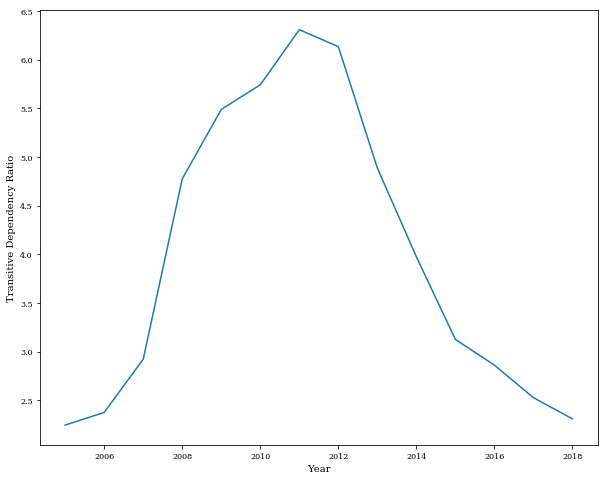

In [16]:
plt.figure(figsize=(10,8))

plt.plot(years, ratios)
plt.xlabel('Year')
plt.ylabel('Transitive Dependency Ratio')